In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
import copy
from sklearn import linear_model
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import validation_curve
from sklearn.metrics import make_scorer
import string

In [2]:
plt.style.use('bmh')
plt.rcParams.update({'figure.figsize': (6,4)})
plt.rcParams.update({'font.size': 7})
plt.rcParams.update({"font.family": "DejaVu Sans"})

## Data pre-processing

In [3]:
#netcdf path
nc_path = '../../hydropt_4_sent3/data/interim/D20200125_125223_PACE_FF0014/*.nc'

In [4]:
ds = xr.open_mfdataset(nc_path, combine='by_coords')

In [5]:
# subset dataset for just above (Ed) and below (IOPs) sea-surface parameter values
ds = ds.isel(geom_depth=0, geom_depth_air=0, suntheta=0)

In [6]:
# calculate rrs
ds['rrs'] = ds.RADMa/ds.Ed

In [7]:
# subset for NADIR viewing angles
ds_nadir = ds.isel(phi=0, fmu=9)

In [8]:
# select total absorption, total backscatter coefficients and Rrs
var = ['acoef', 'bbcoef', 'rrs']
ds_nadir = ds_nadir[var]

In [9]:
ds_df = ds_nadir.to_dataframe()

In [10]:
wbands = ds_df.index.get_level_values('wavelength').unique()

## Model cross-validation

In [11]:
model = make_pipeline(PolynomialFeatures(), linear_model.LinearRegression())

In [12]:
def exp_rmsre(y, yhat):
    n = len(y)
    fdiff = ((np.exp(y)-np.exp(yhat))/np.exp(y))**2
    loss = np.sqrt(np.sum(fdiff)/n)
    
    return loss

In [13]:
exp_root_mean_squared_relative_error = make_scorer(exp_rmsre, greater_is_better=True)

In [77]:
train_scores = {}
val_scores = {}

for idx, data in ds_df.groupby('wavelength'):
    # log transform independent variables
    X = np.log(data[['acoef', 'bbcoef']])
    # dependent variable (i.e. Rrs)
    Y = np.log(data[['rrs']])
    
    degree = np.arange(1, 10)
    train_score, val_score = validation_curve(model, X, Y, param_name='polynomialfeatures__degree', param_range=degree, cv=10,
                                          scoring=exp_root_mean_squared_relative_error)
    
    train_scores[idx] = {'mean': (np.mean(train_score, 1)),
                         'std': np.std(train_score,1)}
    val_scores[idx] = {'mean': (np.mean(val_score, 1)),
                       'std': np.std(val_score,1)}

In [21]:
# calculate validation score for every polynomial degree averaged over all wavebands
val_scores_mean = np.array([val_scores[i]['mean'] for i in wbands]).mean(axis=0)
# calculate 15.7% and 84,3% quantiles (+- 1 std)
val_scores_qntl = np.array([
    np.quantile(np.array([val_scores[i]['mean'] for i in wbands]), .157, axis=0),
    np.quantile(np.array([val_scores[i]['mean'] for i in wbands]), .843, axis=0)
])

In [22]:
# calculate train score for every polynomial degree averaged over all wavebands
train_scores_mean = np.array([train_scores[i]['mean'] for i in wbands]).mean(axis=0)
# calculate 15.7% and 84,3% quantiles (+- 1 std)
train_scores_qntl = np.array([
    np.quantile(np.array([train_scores[i]['mean'] for i in wbands]), .157, axis=0),
    np.quantile(np.array([train_scores[i]['mean'] for i in wbands]), .843, axis=0)
])

(-0.5, 8.0)

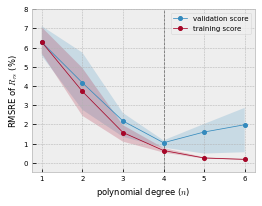

In [23]:
degree_range = slice(0,6)
# to percent
perc = 100

plt.figure(figsize=(4,3))
plt.axvline(4, linestyle='dashed', linewidth=.75, color='black', alpha=.5)
# validation curve
plt.plot(degree[degree_range], val_scores_mean[degree_range]*perc, marker='o', label='validation score', linewidth=.75, markersize=4)
plt.fill_between(degree[degree_range],
                val_scores_qntl[0][degree_range]*perc,
                val_scores_qntl[1][degree_range]*perc,
                alpha=.2)

# training curve
plt.plot(degree[degree_range], train_scores_mean[degree_range]*perc, marker='o', linewidth=.75, markersize=4, label='training score')
plt.fill_between(degree[degree_range],
                train_scores_qntl[0][degree_range]*perc,
                train_scores_qntl[1][degree_range]*perc,
                alpha=.2)


plt.legend(loc='best')
#plt.ylim(-.01, 0.001)
plt.xlabel('polynomial degree ($n$)')
plt.ylabel('RMSRE of $R_{rs}$ (%)')
plt.ylim(-.5, 8)
#plt.figure(figsize=(4,2))
#plt.savefig('cross_validation.svg', format='svg')

In [18]:
def calculate_error(x, degree):
    X = np.log(x[['acoef','bbcoef']])
    Y = np.log(x['rrs'])
    model.set_params(polynomialfeatures__degree=degree)
    rrs_hat = model\
                .fit(X,Y)\
                .predict(X)
#     # log transform independent variables
#     X_all = np.log(ds_df[['acoef', 'bbcoef']])
#     # dependent variable (i.e. Rrs)
#     Y_all = np.log(ds_df[['rrs']])
#     # create nth degree polynomial features
#     X_poly_all = PolynomialFeatures(degree).fit_transform(X_all)
#     # fit model
#     model_all = linear_model.LinearRegression().fit(X_poly_all, Y_all)
#     rrs_hat = model_all.predict(PolynomialFeatures(degree).fit_transform(X))
    # relative error
    delta = (np.exp(rrs_hat) - np.exp(Y))/np.exp(Y)*100
    
    return delta

In [15]:
rrs_error = ds_df\
    .groupby('wavelength')\
    .apply(calculate_error, 4)

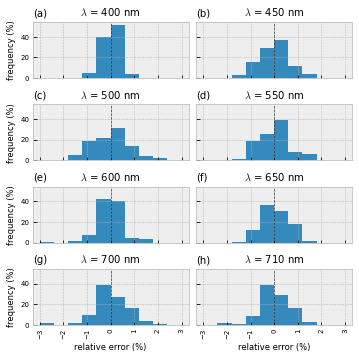

In [26]:
wb_sel = np.append(np.arange(400,711,50), 710)
axs = rrs_error\
        .to_frame()\
        .loc[wb_sel]\
        .hist(by='wavelength',
              layout=(4,2),
              figsize=(5,5),
              range=(-3,3),
              density=False,
              bins=10,
              sharex=True, sharey=True);
# number of samples per waveband
n = rrs_error.loc[wb_sel[0]].size


# adjust axes
for (ax,no) in zip(axs.flatten(), list(string.ascii_lowercase)):
    ax.set_xlabel('relative error (%)')
    ax.set_ylabel('frequency (%)')
    ax.axvline(0, linestyle='--', linewidth=.7, color='black', alpha=.7)
    ax.yaxis.set_major_formatter(lambda x, pos: int((x/n)*100))
    ax.set_title('({})'.format(no), loc='left')
    ax.set_title('$\lambda$ = {} nm'.format(int(float(ax.get_title('center')))), loc='center')
    # plt.xticks(rotation=90)
#plt.ylabel('relative error in $R_{rs}$ (%)')
#plt.title('relative error per waveband')
#plt.ylim(-10,10)
# plt.title('')
# plt.suptitle(' ')
plt.tight_layout()
#plt.savefig('waveband_error.svg', format='svg')

In [27]:
## short way to fit multivariate regression
# X = np.array([
#     [1, 1], [1, 2], [2, 2], [2, 3],
#     [1, 1], [1, 2], [2, 2], [2, 3]])

# # y = 1 * x_0 + 2 * x_1 + 3
# y = np.dot(X, np.array([[1, 2], [2,3]])) + [3, 4]
# reg = linear_model.LinearRegression().fit(X, y)

In [28]:
def fit_multivariate_polynomial(data, x, y, degree, index='wavelength'):  
    # coefficients
    cf = pd.DataFrame()

    for idx, value in data.groupby(index):
        # log transform independent variables
        X = np.log(value[x])
        # dependent variable (i.e. Rrs)
        Y = np.log(value[[y]])
        # create nth degree polynomial features
        X_poly = PolynomialFeatures(degree).fit_transform(X)
        # fit model
        model = linear_model.LinearRegression().fit(X_poly,Y)
        # save polynomial coefficients
        coeff = copy.deepcopy(model.coef_)
        #replace first coefficent by intercept (assuming first coefficient is always 0)
        coeff[0][0] = model.intercept_
        cf = cf.append(pd.DataFrame(coeff))
        
    # rename columns to polynomial terms
    cf\
       .set_axis(PolynomialFeatures(degree=degree)\
       .fit(X)\
       .get_feature_names(['a', 'bb']), axis=1, inplace=True)
    # set wavebands as index
    cf\
      .set_index(data.index.get_level_values(index).unique(),
                 inplace=True)
    
    return cf

In [29]:
pcoef = fit_multivariate_polynomial(ds_df, x=['acoef', 'bbcoef'], y='rrs', degree=4)

In [31]:
#pcoef.to_csv('../hydropt/data/PACE_polynom_04_h2o.csv')

Plot some of the coefficients of the polynomial model as a function of wavelength

In [ ]:
(pcoef/pcoef.loc[400])[['a', 'bb']]\
    .rename(columns={'a':  '$c_{1,0}$',
                     'bb': '$c_{0,1}$'})\
    .plot(marker='o')
plt.ylim(0,7)
plt.ylabel('coefficients normalized at 400 nm')
plt.legend(prop={'size':12})

### Viewing angle

In [15]:
# select data at waveband 440
ds_wb440 = ds.sel(wavelength=440)[var]

In [16]:
df_wb440 = ds_wb440.to_dataframe()

In [11]:
df_wb440.reset_index(inplace=True)

In [12]:
# remove last 23 entries in RADMa
# remove all phi entries for fmu==0.998.. except for phi==0 (which is NADIR)
idx = np.unique(df_wb440\
        .set_index(['fmu','phi'])\
        .index)[-23:]

In [17]:
rrs_440_geom_error = df_wb440.set_index(['fmu','phi'])\
       .drop(idx)\
       .reset_index()\
       .groupby(['fmu','phi'])\
       .apply(calculate_error, degree=4)\
       .abs()\
       .mean(level=['fmu','phi'])

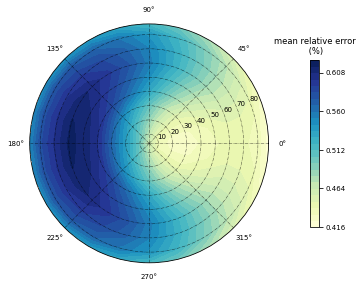

In [67]:
# get fmu and phi values
fmu = np.unique(ds.fmu)
phi = np.unique(ds.phi)
# calculate zeniths in degrees
zeniths = np.degrees(np.arccos(fmu))
values = rrs_440_geom_error.values
#values = rrs_442_geom_error.values
# get the 23 values of the polar cap and append to values
values = np.append(values, np.repeat(values[-1], 23))
# reshape
values = values.reshape(zeniths.size, phi.size)
# add 360 deg to azimuth angles
phi = np.append(phi, 2*np.pi)
# transpose
values = values.T
# 0 deg should be the same as 360 deg
values = np.vstack([values, values[0]])

r, theta = np.meshgrid(zeniths, phi)
fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(111, projection='polar')
cax = ax.contourf(theta, r, values, 30, cmap='YlGnBu')

ax.grid(True, linewidth=.5, linestyle='-.', color='black', alpha=.7)
#cax.set_clim(0,1)
cbar = fig.colorbar(cax, shrink=.7, pad=.1)
cbar.ax.set_title('mean relative error\n (%)')
cbar.ax.locator_params(nbins=5)

plt.tight_layout()
#plt.savefig('rrs_440_view_geom_error.svg', format='svg')
#ax.set_title('CDOM: 0.005 $m^{-1}$, Chl: 31 $mg\ m^{-3}$, NAP: 100 $g\ m^{-3}$')

## Visualization

In [25]:
import plotly.express as px

In [121]:
data = ds_df.reset_index(['CDOM', 'NAP', 'Chl']).loc[np.arange(400,710, 10)]

In [122]:
data = np.log(data[var])
data = data.reset_index()

In [ ]:
fig = px.scatter_3d(data, x='acoef', y='bbcoef', z='rrs',
                    color='wavelength', size_max=1, width=600, height=800)
fig.update_traces(marker=dict(size=3))
fig.show()